## Compare the counts in both the chrM and the variant regions
### Heatmaps for them. Also do AFs correlate with variants

In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
NUM_DONORS=2
prob_threshold=0.8
INDIR = "./"
config_f = "parameters/2020_11_18.yaml"
OUTDIR='./results/'


In [3]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [4]:
# if not os.path.exists(OUTDIR):
#     os.mkdir(OUTDIR)

#os.chdir(INDIR)

In [5]:
import os
from itertools import product
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join, dirname, basename
import numpy as np

In [6]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread

In [7]:
import glob
from src.utils.parse_config import read_config_file
config = read_config_file(config_f)
config

{'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/2020_11_18_Croker/MTblacklist',
 'variants_f': '/data2/mito_lineage/data/external/cellSNP_variants/processed/liftOver_chr_full_genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf',
 'genome_size': '/data/isshamie/mito_lineage/data/external/GRCh38_MT_blacklist/fasta/genome.chrom.size',
 'use_mt_bam': True,
 'mttrace_dir': '/data2/mito_lineage/data/processed/mttrace/2020_11_18/',
 'samples': ['PBMC_J', 'PBMC_P'],
 'pseudo_multiplex': {'num_cells': 2000, 'is_proportional': False},
 'mt': {'minMAF': [0.001], 'minCOUNT': [1]},
 'pre_variant': {'minMAF': [0.1], 'minCOUNT': [20]}}

## Loading cellSNP pileup data

In [8]:
def load_mtx_df(in_f, skip_first=True, give_header=False):
    df = pd.read_csv(in_f, comment="%", header=None, sep="\t")
    df.columns = ["Variant", "Cell", "integer"]

    if skip_first:
        head = df.iloc[0]
        df = df.iloc[1:] # Seems to be summary values
    if give_header:
        return df,head
    return df

def load_pileup(indir, use_oth=False):
    curr_dp_f = join(indir, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(indir, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(indir, "cellSNP.tag.OTH.mtx")
    vcf_f = join(indir, "cellSNP.base.vcf")
    if not os.path.exists(vcf_f):
        if not os.path.exists(vcf_f + ".gz"):
            raise ValueError("VCF file not here!")
        else:
            vcf_f = vcf_f + ".gz"
    dp = load_mtx_df(curr_dp_f)
    ad = load_mtx_df(curr_ad_f)
    vcf = pd.read_csv(vcf_f, skiprows=1, sep="\t")
    if os.path.exists(curr_oth_f) and use_oth:
        oth = load_mtx_df(curr_oth_f)
        return dp, ad, oth, vcf
    return dp, ad, vcf

def load_mtx_df_full(in_f, vcf_f=None):
    df = pd.DataFrame(mmread(in_f).tocsc().todense())
    df.index.name = "Variant"
    df.columns.name = "Cell"
    if vcf_f is None:
        return df
    vcf = pd.read_csv(vcf_f, sep='\t', skiprows=1)
    print(f" {in_f} shape {df.shape}")
    df = pd.merge(df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    return df

def load_pileup_full(indir, use_oth=False):
    curr_dp_f = join(indir, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(indir, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(indir, "cellSNP.tag.OTH.mtx")
    curr_barcode_f = join(indir, "cellSNP.samples.tsv")
    vcf_f = join(indir, "cellSNP.base.vcf")
    if not os.path.exists(vcf_f):
        if not os.path.exists(vcf_f + ".gz"):
            raise ValueError("VCF file not here!")
        else:
            vcf_f = vcf_f + ".gz"
    dp = load_mtx_df_full(curr_dp_f, vcf_f)
    ad = load_mtx_df_full(curr_ad_f, vcf_f)
    vcf = pd.read_csv(vcf_f, skiprows=1, sep="\t")
    barcode = pd.read_csv(curr_barcode_f, header=None)[0].values
    if os.path.exists(curr_oth_f) and use_oth:
        oth = load_mtx_df_full(curr_oth_f, load_mtx_df_full)
        return dp, ad, oth, vcf
    return dp, ad, vcf, barcode

### MT

In [9]:
mt_counts = pd.DataFrame(product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]), 
                                columns=["sample", "minCount", "minAF"])
#{"Donor": [], "mt_minAF": [], "mt_minCount":[], "minAF":[], "minCount":[]}
all_ad = {}
all_dp = {}
all_vcf = {}
all_barcodes={}
#for sample, minCount, minAF in product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]):    
for ind, val in mt_counts.iterrows():
    curr_dir = f"data/chrM/{val['sample']}_cellSNP_minC{val['minCount']}_minAF{val['minAF']}/"
    print(curr_dir)
    dp, ad, vcf, barcode = load_pileup_full(curr_dir)
    all_ad[ind] = ad
    all_dp[ind] = dp
    all_vcf[ind] = vcf
    all_barcodes[ind] = barcode

data/chrM/PBMC_J_cellSNP_minC1_minAF0.001/
 data/chrM/PBMC_J_cellSNP_minC1_minAF0.001/cellSNP.tag.DP.mtx shape (10743, 743)
 data/chrM/PBMC_J_cellSNP_minC1_minAF0.001/cellSNP.tag.AD.mtx shape (10743, 743)
data/chrM/PBMC_P_cellSNP_minC1_minAF0.001/
 data/chrM/PBMC_P_cellSNP_minC1_minAF0.001/cellSNP.tag.DP.mtx shape (10593, 663)
 data/chrM/PBMC_P_cellSNP_minC1_minAF0.001/cellSNP.tag.AD.mtx shape (10593, 663)


In [10]:
mt_counts

,sample,minCount,minAF
0,PBMC_J,1,0.001
1,PBMC_P,1,0.001


## Look at minAF=0.01 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

KeyboardInterrupt: 

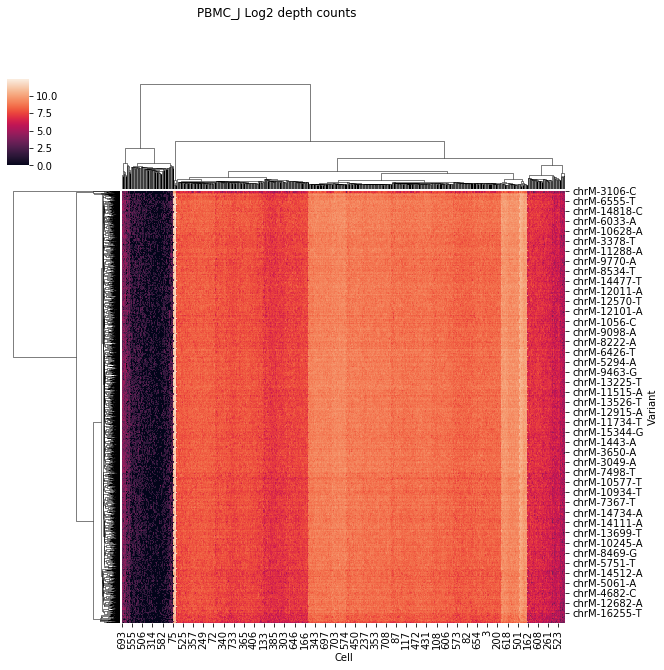

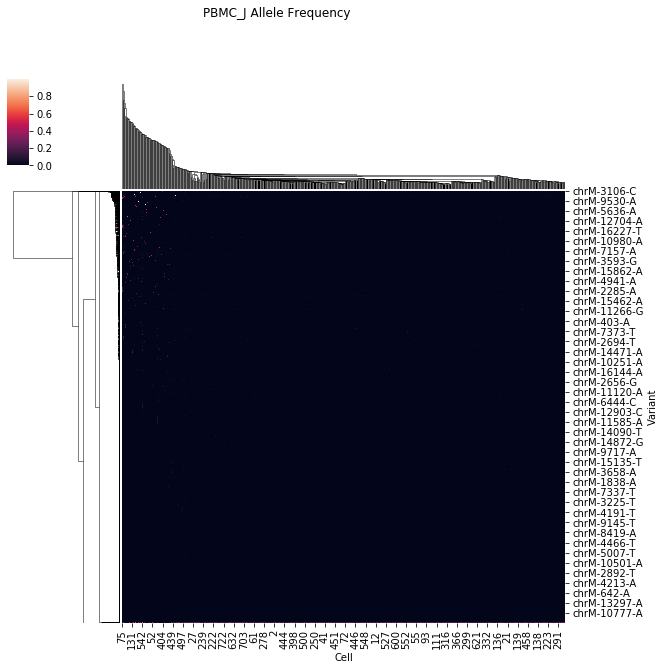

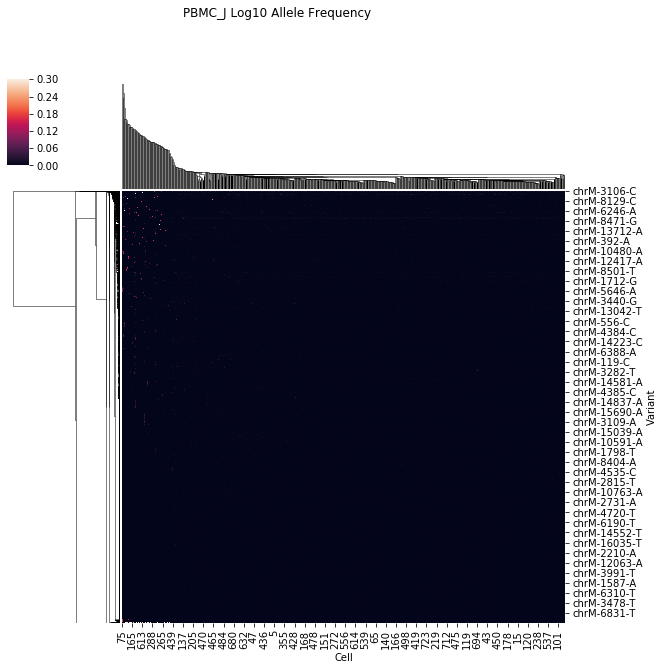

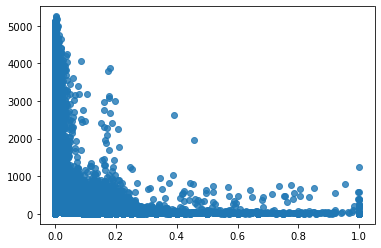

In [23]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]


minAF = 0.001
minCount = 1
curr_val = mt_counts[(mt_counts["minAF"] == minAF) & (minCount == mt_counts["minCount"])]

for ind, val in curr_val.iterrows():
    g = sns.clustermap(np.log2(1+all_dp[ind]))
    plt.suptitle(f"{val['sample']} Log2 depth counts")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")

    curr_af = all_ad[ind]/(all_dp[ind]+0.0002)

    g = sns.clustermap(curr_af)
    plt.suptitle(f"{val['sample']} Allele Frequency")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")


    g = sns.clustermap(np.log10(curr_af+1))
    plt.suptitle(f"{val['sample']} Log10 Allele Frequency")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")

    
    # Correlate AF and depth
    curr_af_melt = curr_af.reset_index().melt(value_name='AF', value_vars=curr_af.columns, id_vars=["#CHROM", "POS", "ALT"])
    curr_dp_melt = all_dp[ind].melt(value_name='Count', value_vars=all_dp[ind].columns).pipe(drop_zero_count)
    
    #pd.merge(curr_af_melt, curr_dp_melt, left_index=True, right_index=True, how="inner")
    f = plt.figure()
    sns.regplot(x="AF", y="Count", data=pd.merge(curr_af_melt, 
                                                 curr_dp_melt, left_index=True, right_index=True, how="inner"))


In [24]:
#from glasbey import Glasbey
# def plot_domain(names, curr_ax=None, name=None, to_transpose=False):
#     gb = Glasbey()
#     curr_domain_names = curr_domains["Pfam Name"].unique()
#     p = gb.generate_palette(size=len(curr_domain_names) + 1)
#     # Needed for Float problems
#     p[p > 1] = 1
#     p[p < 0] = 0
#     # print(p)
#     # domain_plot.loc[:,:] = [0,0,0]
    
#     color_map = {dom: p[ind + 1] for ind, dom in
#                  enumerate(curr_domains["Pfam Name"].unique())}
#     pfam_map = {val: ind for ind, val in enumerate(curr_domain_names)}

#     if max(curr_domains["Pfam end"].astype(int)) is None:
#         print("Pfam end not there")
#         return

#     domain_plot_1 = np.zeros([max(curr_domains["Pfam end"].astype(int)),
#                               len(curr_domain_names), 3])
#     for i in range(domain_plot_1.shape[0]):
#         for j in range(domain_plot_1.shape[1]):
#             domain_plot_1[i, j, :] = p[0]

#     for ind, val in curr_domains.iterrows():
#         for i in range(val["Pfam start"] - 1, val["Pfam end"]):
#             domain_plot_1[i, pfam_map[val["Pfam Name"]], :] = color_map[
#                 val[
#                     "Pfam Name"]]  # domain_plot.loc[range(val["Pfam start"], val["Pfam end"]+1), val["Pfam ID"]] = color_map[val["Pfam ID"]]

#     if curr_ax is not None:
#         if to_transpose:
#             curr_ax.imshow(np.transpose(domain_plot_1, axes=[1, 0, 2]),
#                            aspect='auto')
#         else:
#             curr_ax.imshow(domain_plot_1,aspect='auto')
#         # curr_ax.imshow(domain_plot_1,aspect='auto')#,cmap='BuPu')

#         # plt.axis('tight')
#        # curr_ax.set_xticks([])
#        # curr_ax.set_yticks([])  # plt.legend(pfam_map.keys())

#     markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o',
#                           linestyle='') for color in color_map.values()]
#     markers.append(plt.Line2D([0, 0], [0, 0], color=p[0], marker='o',
#                               linestyle=''))
#     curr_ax.legend(markers, list(color_map.keys()) + ["None"],
#                    numpoints=1, loc='upper right')

#     return


def plot_heatmap_with_barplot_marginal(df, marginal_x=None, marginal_y=None):

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]
    rect_color = [left + width + spacing, bottom + height + spacing,
                  0.15, 0.15]
    # start with a square Figure
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_axes(rect_scatter)
    ax_cbar = fig.add_axes(rect_color)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)


    ax = sns.heatmap(df, ax=ax, cbar_ax=ax_cbar,xticklabels='auto',yticklabels='auto')

    if marginal_x is not None:
        marginal_x.plot.bar(rot=90, ax=ax_histx)
        ax_histx.set_xticklabels([])
    if marginal_y is not None:
        marginal_y.plot.barh(rot=90, ax=ax_histy)
        ax_histy.set_yticklabels([])
    #plot_domain(domains_2, name=None, curr_ax=ax_histx, to_transpose=True)
    #plot_domain(domains_1, name=None, curr_ax=ax_histy,to_transpose=False)
    #helper_save(f_save_fig,to_svg=False)
    return

## Merge PBMC J and P variants

In [25]:
# Change the indices of the cells
merged_af = pd.DataFrame(index=all_dp[0].index)
merged_dp = pd.DataFrame(index=all_dp[0].index)
sample_color_map = {"PBMC_J": "Blue", "PBMC_P": "Red"}
cell_color_map = {}
vars_intersection = {}
for ind, val in curr_val.iterrows():
    curr_af = all_ad[ind]/(all_dp[ind]+0.0002).copy()
    curr_dp = all_dp[ind].copy()
    vars_intersection[ind] = set(curr_dp.index)
    curr_dp.columns = map(lambda x: val['sample']+"_"+str(x), curr_dp.columns.values)
    curr_af.columns = map(lambda x: val['sample']+"_"+str(x), curr_af.columns.values)
    merged_af = pd.merge(merged_af, curr_af, left_index=True, right_index=True, how='outer')
    merged_dp = pd.merge(merged_dp, curr_dp, left_index=True, right_index=True, how='outer')
    for i in curr_dp.columns:
        cell_color_map[i] = sample_color_map[val['sample']]
merged_af = merged_af.fillna(0)
merged_dp = merged_dp.fillna(0)

In [26]:
merged_dp.sum(axis=1)

#CHROM  POS    ALT
chrM    1      C      174170.0
        3      A      205156.0
        8      T      240449.0
        10     A      280605.0
        14     A      307033.0
                        ...   
        16551  A      459264.0
        16554  T      452288.0
        16558  T      401931.0
        16559  T      397889.0
        16564  T      119346.0
Length: 11788, dtype: float64

In [27]:
merged_af

PBMC_J_0  PBMC_J_1  PBMC_J_2  PBMC_J_3  PBMC_J_4  PBMC_J_5  \
#CHROM POS   ALT                                                               
chrM   1     C    0.000000       0.0       0.0  0.000000       0.0  0.000000   
       3     A    0.000000       0.0       0.0  0.000000       0.0  0.000000   
       8     T    0.000000       0.0       0.0  0.000000       0.0  0.000000   
       10    A    0.000000       0.0       0.0  0.000000       0.0  0.000000   
       14    A    0.000000       0.0       0.0  0.000000       0.0  0.000000   
...                    ...       ...       ...       ...       ...       ...   
       16551 A    0.000000       0.0       0.0  0.000000       0.0  0.005848   
       16554 T    0.001938       0.0       0.0  0.003436       0.0  0.005882   
       16558 T    0.000000       0.0       0.0  0.000000       0.0  0.000000   
       16559 T    0.000000       0.0       0.0  0.000000       0.0  0.006410   
       16564 T    0.002681       0.0       0.0  0.000000       0.0  0.000000   

                  PBMC_J_6  PBMC_J_7  PBMC_J_8  PBMC_J_9  ...  PBMC_P_653  \
#CHROM POS   ALT                                          ...               
chrM   1     C    0.000000  0.000000  0.000000       0.0  ...    0.003448   
       3     A    0.000000  0.000000  0.000000       0.0  ...    0.004878   
       8     T    0.000000  0.000000  0.000000       0.0  ...    0.000000   
       10    A    0.000000  0.000000  0.000000       0.0  ...    0.000000   
       14    A    0.000000  0.000000  0.000000       0.0  ...    0.001550   
...                    ...       ...       ...       ...  ...         ...   
       16551 A    0.004000  0.000000  0.000000       0.0  ...    0.000000   
       16554 T    0.002045  0.003676  0.000000       0.0  ...    0.000000   
       16558 T    0.002217  0.003759  0.006452       0.0  ...    0.000000   
       16559 T    0.000000  0.000000  0.012903       0.0  ...    0.001475   
       16564 T    0.000000  0.000000  0.000000       0.0  ...    0.000000   

                  PBMC_P_654  PBMC_P_655  PBMC_P_656  PBMC_P_657  PBMC_P_658  \
#CHROM POS   ALT                                                               
chrM   1     C      0.000000    0.000000    0.000000    0.000000         0.0   
       3     A      0.000000    0.004386    0.000000    0.000000         0.0   
       8     T      0.005814    0.000000    0.000000    0.000000         0.0   
       10    A      0.000000    0.005571    0.010256    0.000000         0.0   
       14    A      0.005076    0.002591    0.000000    0.000000         0.0   
...                      ...         ...         ...         ...         ...   
       16551 A      0.003311    0.000000    0.000000    0.001764         0.0   
       16554 T      0.003311    0.001610    0.000000    0.005425         0.0   
       16558 T      0.000000    0.001815    0.004566    0.002096         0.0   
       16559 T      0.000000    0.003766    0.004566    0.002141         0.0   
       16564 T      0.000000    0.000000    0.000000    0.000000         0.0   

                  PBMC_P_659  PBMC_P_660  PBMC_P_661  PBMC_P_662  
#CHROM POS   ALT                                                  
chrM   1     C      0.000000    0.000000    0.000000    0.000000  
       3     A      0.000000    0.000000    0.000000    0.000000  
       8     T      0.000000    0.000000    0.000000    0.000000  
       10    A      0.000000    0.000000    0.003617    0.000000  
       14    A      0.000000    0.005013    0.001520    0.000000  
...                      ...         ...         ...         ...  
       16551 A      0.000000    0.000000    0.000000    0.002584  
       16554 T      0.000000    0.000000    0.000000    0.000000  
       16558 T      0.002688    0.000000    0.001495    0.000000  
       16559 T      0.000000    0.003656    0.000000    0.000000  
       16564 T      0.000000    0.000000    0.000000    0.000000  

[11788 rows x 1406 columns]

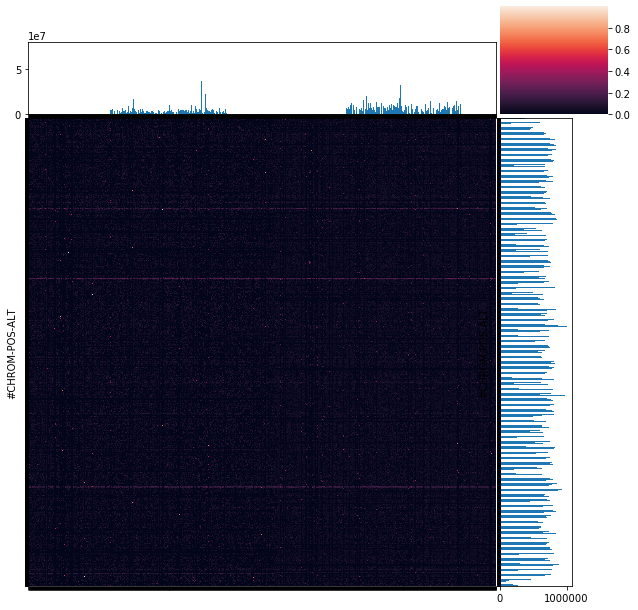

In [28]:
plot_heatmap_with_barplot_marginal(np.sqrt(merged_af.fillna(0)), 
                                   marginal_x=merged_dp.sum(axis=0), 
                                   marginal_y=merged_dp.sum(axis=1))


#merged_dp.sum(axis=1)

[]

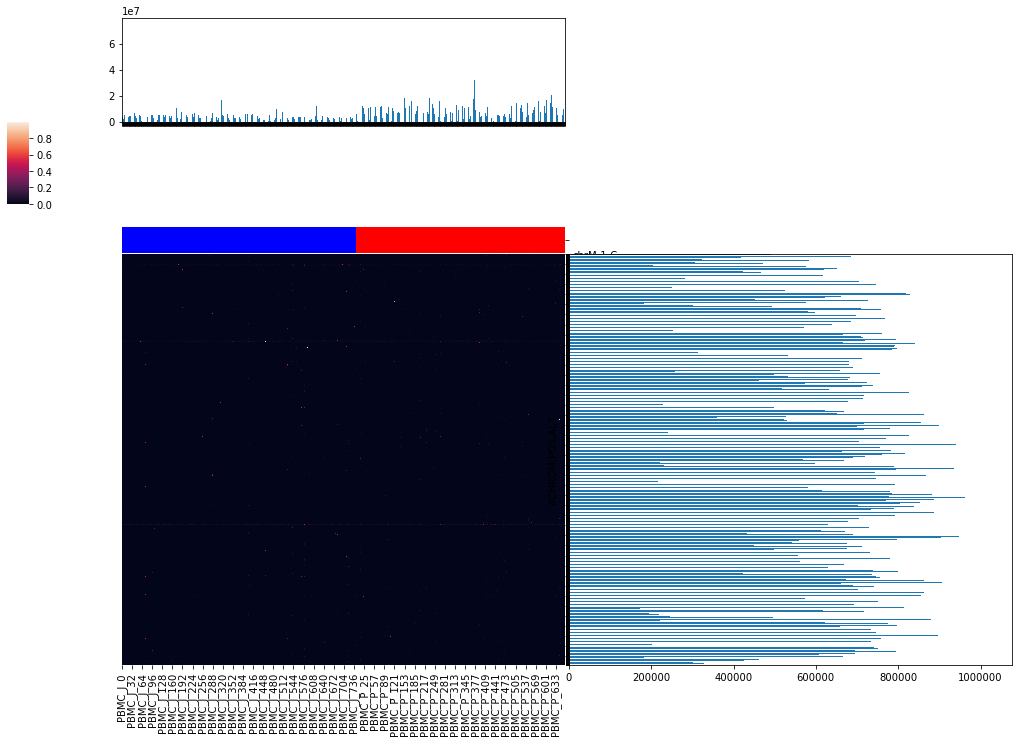

In [29]:
g = sns.clustermap(merged_af.fillna(0), col_cluster=False, row_cluster=False, col_colors=pd.Series(cell_color_map))
fig = g.fig

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
#spacing = 0.0005

# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.1]
# rect_histy = [left + width + spacing, bottom, 0.1, height]
# rect_color = [left + width + spacing, bottom + height + spacing,
#               0.15, 0.15]

rect_histx = [g.ax_heatmap.get_position().bounds[0],
              g.ax_col_dendrogram.get_position().bounds[1]+g.ax_col_dendrogram.get_position().bounds[3]+0, 
              g.ax_heatmap.get_position().bounds[2], 
              g.ax_col_dendrogram.get_position().bounds[3]]
#ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx)

merged_dp.sum(axis=0).plot.bar(rot=90, ax=ax_histx)
ax_histx.set_xticklabels([])


rect_histy = [g.ax_heatmap.get_position().bounds[0]+g.ax_heatmap.get_position().bounds[2]+spacing,
              g.ax_heatmap.get_position().bounds[1], 
              rect_histx[2],
              g.ax_heatmap.get_position().bounds[3]]
ax_histy = fig.add_axes(rect_histy)
merged_dp.sum(axis=1).plot.barh(rot=90, ax=ax_histy)
ax_histy.set_yticklabels([])

#ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)


In [30]:
from src.external.pyvenn import venn

Text(0, 0.5, 'Overlapping Variants')

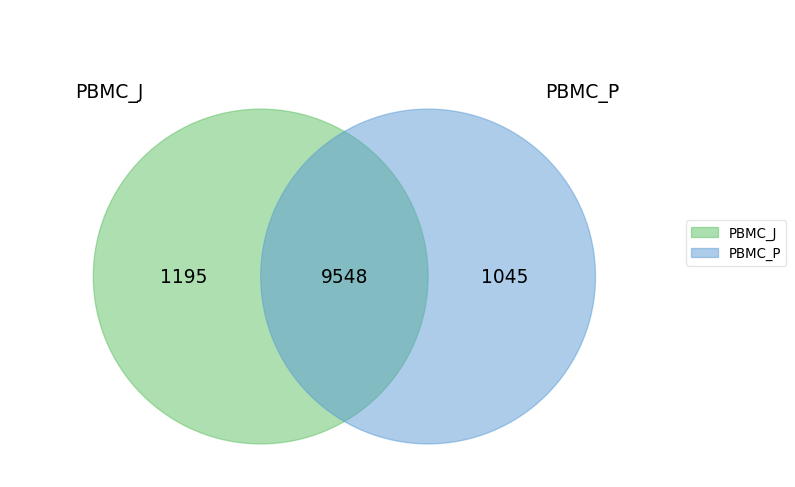

In [31]:
%matplotlib inline
labels = venn.get_labels(list(vars_intersection.values()))
venn.venn2(labels, names=list(map(lambda x: mt_counts.loc[x, "sample"], list(vars_intersection.keys()))))
plt.ylabel("Overlapping Variants")

In [37]:
(merged_af==0).all(axis=1).any()

False

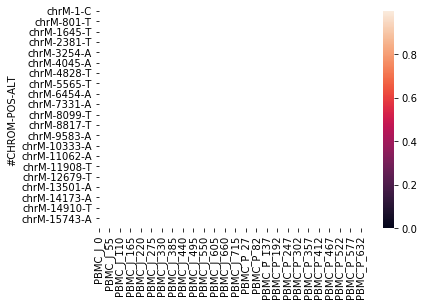

In [38]:
sns.heatmap(np.sqrt(merged_af.fillna(0)))

In [41]:
len(vars_intersection)

2

In [42]:
len(set(vars_intersection[0]).intersection(set(vars_intersection[1])))

9548

In [45]:
het=0.02
bin_merged_af = merged_af.copy()
bin_merged_af[bin_merged_af<het] = 0
bin_merged_af[bin_merged_af>0] = 1

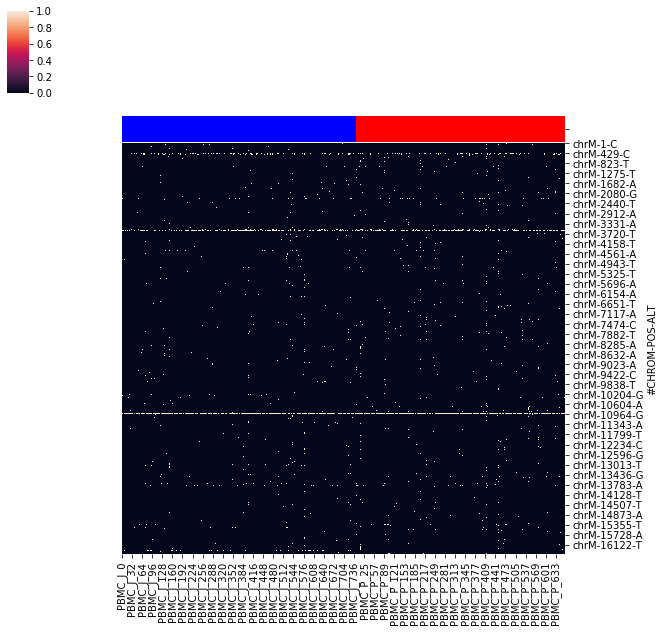

In [47]:
sns.clustermap(bin_merged_af, row_cluster=False, metric='jaccard',col_cluster=False, col_colors=pd.Series(cell_color_map))

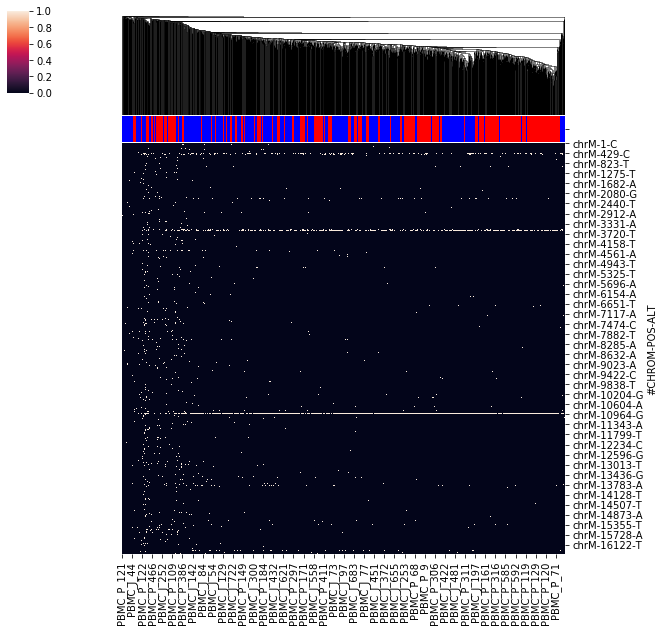

In [49]:
sns.clustermap(bin_merged_af, row_cluster=False, metric='jaccard',col_cluster=True, col_colors=pd.Series(cell_color_map))

In [ ]:
sns.clustermap(np.sqrt(merged_af.fillna(0)), col_cluster=True,
               col_colors=pd.Series(cell_color_map))

In [ ]:
sns.clustermap(merged_dp.fillna(0), col_cluster=True, col_colors=pd.Series(cell_color_map))

In [ ]:
sns.clustermap(np.log2(1+merged_dp.fillna(0)), col_cluster=True, col_colors=pd.Series(cell_color_map))

### Correlate low peak counts with MT expression

In [ ]:
sample = val["sample"]
peak_dir = join(config['indir'], sample, "outs", "filtered_peak_bc_matrix")
peaks = load_mtx_df_full((join(peak_dir, "matrix.mtx")), vcf_f=None)
peaks.index.name = "Peak"
peak_barcodes = pd.read_csv(join(peak_dir, "barcodes.tsv"), header=None)[0].values


## The peak ID and the pileup cell barcodes have the same order, seen here:

In [ ]:
(peak_barcodes == all_barcodes[ind]).all()

In [ ]:
cell_dp_counts = all_dp[ind].sum()
cell_peak_counts = peaks.sum()
cell_dp_peak_df = pd.concat((cell_dp_counts, cell_peak_counts), axis=1)
cell_dp_peak_df.columns=["MT Depth", "Peak Counts"]
cell_dp_peak_df

In [ ]:
sns.regplot(x="MT Depth", y="Peak Counts" , data=cell_dp_peak_df)

In [ ]:
sns.regplot(x="MT Depth", y="Peak Counts" , data=np.log10(cell_dp_peak_df))

### For each MT minCount-minAF create headmap separately for both samples

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


sample_map = {val:ind for ind, val in enumerate(mt_counts["sample"].unique())}
gs_map_row = {val:ind for ind, val in enumerate(mt_counts["minAF"].unique())}
gs_map_col = {val:ind for ind, val in enumerate(mt_counts["minCount"].unique())}

#fig = plt.figure(figsize=(10,20))
fig = plt.figure()
gs = fig.add_gridspec(len(mt_counts["minAF"].unique()),len(sample_map)*len(mt_counts["minCount"].unique()-1))

for ind, val in mt_counts.groupby(["minAF", "minCount"]):
    print('ind')
    print(val)
    curr_row = gs_map_row[ind[0]]
    curr_col = gs_map_col[ind[1]]*len(sample_map)
    for sample, val2 in val.reset_index().set_index("sample").iterrows():
        print('sample', sample)
        print("gridspec indices:")
        print(curr_row, (curr_col)+sample_map[sample])
        curr_ax = fig.add_subplot(gs[curr_row, curr_col+sample_map[sample]])
        sns.heatmap(all_ad[val2["index"]], ax=curr_ax,xticklabels=False, 
                    yticklabels=False, square=False, cbar=False)
        plt.ylabel("Variant")
        plt.xlabel("Cell")
        num_variants, num_cells = all_ad[val2["index"]].shape
        plt.title(f"{sample} \nminAF: {ind[0]}\n minCount: {ind[1]}\n #Cells: {num_cells}\n#Variants: {num_variants}")
plt.subplots_adjust(top=0.4)
plt.suptitle("Allele Frequency in MT variants called with Vireo",)
# f3_ax1 = fig3.add_subplot(gs[0, :])
# f3_ax1.set_title('gs[0, :]')
# f3_ax2 = fig3.add_subplot(gs[1, :-1])
# f3_ax2.set_title('gs[1, :-1]')
# f3_ax3 = fig3.add_subplot(gs[1:, -1])
# f3_ax3.set_title('gs[1:, -1]')
# f3_ax4 = fig3.add_subplot(gs[-1, 0])
# f3_ax4.set_title('gs[-1, 0]')
# f3_ax5 = fig3.add_subplot(gs[-1, -2])
# f3_ax5.set_title('gs[-1, -2]')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


sample_map = {val:ind for ind, val in enumerate(mt_counts["sample"].unique())}
gs_map_row = {val:ind for ind, val in enumerate(mt_counts["minAF"].unique())}
gs_map_col = {val:ind for ind, val in enumerate(mt_counts["minCount"].unique())}

fig = plt.figure(figsize=(20,20))
#fig = plt.figure()
gs = fig.add_gridspec(len(mt_counts["minAF"].unique()),len(sample_map)*len(mt_counts["minCount"].unique()-1))

for ind, val in mt_counts.groupby(["minAF", "minCount"]):
    print('ind')
    print(val)
    curr_row = gs_map_row[ind[0]]
    curr_col = gs_map_col[ind[1]]*len(sample_map)
    for sample, val2 in val.reset_index().set_index("sample").iterrows():
        print('sample', sample)
        print("gridspec indices:")
        print(curr_row, (curr_col)+sample_map[sample])
        curr_ax = fig.add_subplot(gs[curr_row, curr_col+sample_map[sample]])
        sns.heatmap(all_dp[val2["index"]], ax=curr_ax,xticklabels=False, yticklabels=False, square=False, cbar=False)
        plt.ylabel("Variant")
        plt.xlabel("Cell")
        num_variants, num_cells = all_dp[val2["index"]].shape
        plt.title(f"{sample} \nminAF: {ind[0]}\n minCount: {ind[1]}\n #Cells: {num_cells}\n#Variants: {num_variants}")
#plt.subplots_adjust(top=0.6)

plt.suptitle("Counts in MT variants called with Vireo")

In [ ]:
f = plt.figure(figsize=(10,10))
sns.clustermap(np.log2(1+all_ad[val2["index"]]), xticklabels=False, yticklabels=False)
plt.title("Log2 allele variant counts")

In [ ]:
f = plt.figure(figsize=(10,10))
sns.clustermap(np.log2(1+all_dp[val2["index"]]), xticklabels=False, yticklabels=False)
plt.title("Log2 depth counts")

In [ ]:
f = plt.figure(figsize=(10,10))
sns.clustermap(all_ad[val2["index"]]/(all_dp[val2["index"]]+0.0002), xticklabels=False, yticklabels=False)
plt.title("Allele Frequency")

In [ ]:
curr_af.reset_index()

In [ ]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]
curr_af = all_ad[val2["index"]]/(all_dp[val2["index"]]+0.0002)
curr_af = curr_af.reset_index().melt(value_name='AF', value_vars=curr_af.columns, id_vars=["#CHROM", "POS", "ALT"])

curr_dp = all_dp[val2["index"]].melt(value_name='Count', value_vars=all_dp[val2["index"]].columns).pipe(drop_zero_count)
curr_dp

In [ ]:
curr_af

In [ ]:
pd.merge(curr_af, curr_dp, left_index=True, right_index=True, how="inner")

sns.regplot(x="AF", y="Count", data=pd.merge(curr_af, curr_dp, left_index=True, right_index=True, how="inner"))

### Variants

In [ ]:
variant_counts = pd.DataFrame(product(config["samples"], config["pre_variant"]["minCOUNT"], 
                                      config["pre_variant"]["minMAF"]), 
                                columns=["sample", "minCount", "minAF"])
#{"Donor": [], "mt_minAF": [], "mt_minCount":[], "minAF":[], "minCount":[]}
all_ad = {}
all_dp = {}
all_vcf = {}
#for sample, minCount, minAF in product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]):    
for ind, val in variant_counts.iterrows():
    curr_dir = f"data/{val['sample']}_cellSNP_minC{val['minCount']}_minAF{val['minAF']}/"
    print(curr_dir)
    dp, ad, vcf = load_pileup(curr_dir)
    all_ad[ind] = ad
    all_dp[ind] = dp
    all_vcf[ind] = vcf
variant_counts

### Load and process input data

In [ ]:
for ind, val in mt_counts.iterrows():
    print(ind)
    DP_df = pd.DataFrame(DP.todense())
    DP_df.index.name = "Variant"
    DP_df.columns.name = "Cell"
    AD_df.index.name = "Variant"
    AD_df.columns.name = "Cell"

    print("AD shape", AD_df.shape)
    print("DP shape", DP_df.shape)
    AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    DP_df = pd.merge(DP_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    AD_df

In [ ]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
vcf = pd.read_csv(VCF_F, sep='\t', skiprows=1)
AD_df = pd.DataFrame(AD.todense())
DP_df = pd.DataFrame(DP.todense())
DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AD_df.index.name = "Variant"
AD_df.columns.name = "Cell"

print("AD shape", AD_df.shape)
print("DP shape", DP_df.shape)
AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
DP_df = pd.merge(DP_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
AD_df

## Create Allele Frequency as AD/(DP+0.001) 

In [ ]:
AF_df = AD_df/(DP_df+0.001)
g = sns.clustermap(AF_df)
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

## Log 10

In [ ]:
AF_df = AD_df/(DP_df+0.001)

g = sns.clustermap(np.log10(AF_df+1))
g.fig.suptitle("Log10(Allele frequency+1)")
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

## Depth

In [ ]:
#AF_df = AD_df/(DP_df+0.001)
g = sns.clustermap(np.log10(DP_df+1))
g.fig.suptitle("Depth")
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

### There shouldnt be cells and variants that are undetected, but we see that below for both Allele Frequencies and read depth

In [ ]:
print(f"Number of cells with no variants detected: {(AF_df == 0).all(axis=0).sum()}")
print(f"Number of variants with no cells having coverage: {(AF_df == 0).all(axis=1).sum()}")

In [ ]:
print(f"Number of cells with no variants detected: {(DP_df == 0).all(axis=0).sum()}")
print(f"Number of variants with no cells having coverage: {(DP_df == 0).all(axis=1).sum()}")

## Remove the 0s in both areas

In [ ]:
def remove_zeros(df, multi_index=False):
    if multi_index:
        df.index = list(map(lambda x: "_".join(np.array(x)), DP_df.index))
    df = df.loc[~((AF_df==0).all(axis=1)),:]
    df = df.loc[:, ~((AF_df==0).all(axis=0))]
    return df

AF_df_filt = remove_zeros(AF_df)
DP_df_filt = remove_zeros(DP_df)

print("After removing variants and cells with all 0s")
print(f"Number of variants left are {AF_df_filt.shape[0]}")
print(f"Number of cells left are {AF_df_filt.shape[1]}")

In [ ]:
AF_joy

In [ ]:
AF_df_filt

In [ ]:
AF_df_filt.reset_index()

In [ ]:
AF_joy

In [ ]:
%matplotlib inline
import joypy
#from matplotlib import pyplot as plt

from matplotlib import cm

AF_joy=AF_df_filt.reset_index().melt(id_vars=["#CHROM","POS","ALT"], value_name="AF")
AF_joy["ID"] = AF_joy.apply(lambda x: f"{x['#CHROM']}_{str(x['POS'])}_{x['ALT']}", axis=1)
AF_joy.head()
                            
#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]
labels = AF_joy["ID"].unique()
fig, axes = joypy.joyplot(AF_joy, by="ID", column="AF", labels=labels, range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Variant Allele Frequencies over single cells",
                          colormap=cm.autumn_r)

# fig, axes = joypy.joyplot(temp, by="Year", column="Anomaly", labels=labels, range_style='own', 
#                           grid="y", linewidth=1, legend=False, figsize=(6,5),
#                           title="Global daily temperature 1880-2014 \n(°C above 1950-80 average)",
#                           colormap=cm.autumn_r)

In [ ]:
%matplotlib inline
import joypy
#from matplotlib import pyplot as plt

from matplotlib import cm

AF_joy=AF_df_filt.reset_index().melt(id_vars=["#CHROM","POS","ALT"], value_name="AF")
AF_joy["ID"] = AF_joy.apply(lambda x: f"{x['#CHROM']}_{str(x['POS'])}_{x['ALT']}", axis=1)
AF_joy.head()
                            
#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]
labels = AF_joy["ID"].unique()
AF_joy["log AF"] = np.log10(AF_joy["AF"]+1)
fig, axes = joypy.joyplot(AF_joy, by="ID", column="log AF", labels=labels, range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Variant Allele Frequencies over single cells",
                          colormap=cm.autumn_r)

# fig, axes = joypy.joyplot(temp, by="Year", column="Anomaly", labels=labels, range_style='own', 
#                           grid="y", linewidth=1, legend=False, figsize=(6,5),
#                           title="Global daily temperature 1880-2014 \n(°C above 1950-80 average)",
#                           colormap=cm.autumn_r)

In [ ]:
AF_joy[AF_joy["AF"]>0]

### Remove all 0s and plot

In [ ]:
%matplotlib inline
import joypy
#from matplotlib import pyplot as plt

from matplotlib import cm

#AF_joy=AF_df_filt.reset_index().melt(id_vars=["#CHROM","POS","ALT"], value_name="AF")
#AF_joy["ID"] = AF_joy.apply(lambda x: f"{x['#CHROM']}_{str(x['POS'])}_{x['ALT']}", axis=1)
                            
#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]


AF_joy_0 = AF_joy[AF_joy["AF"]>0].copy()
labels = AF_joy_0["ID"].unique()
fig, axes = joypy.joyplot(AF_joy_0, by="ID", column="AF", labels=labels, range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Variant Allele Frequencies over single cells",
                          colormap=cm.autumn_r)
